# dataloader demo

In [1]:
import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm
import torch
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset
from experanto.dataloaders import get_multisession_dataloader

#### Load Config Object from .yaml file

In [2]:
from experanto.configs import DEFAULT_CONFIG as cfg
print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  add_behavior_as_channels: false
  replace_nans_with_means: false
  modality_config:
    screen:
      keep_nans: false
      sampling_rate: 30
      chunk_size: 60
      valid_condition:
        tier: train
      offset: 0
      sample_stride: 1
      include_blanks: true
      transforms:
        normalization: screen_default
      interpolation:
        rescale: true
        rescale_size:
        - 36
        - 64
    responses:
      keep_nans: false
      sampling_rate: 8
      chunk_size: 16
      offset: 0.0
      transforms:
        normalization: recompute_responses
      interpolation:
        interpolation_mode: nearest_neighbor
    eye_tracker:
      keep_nans: false
      sampling_rate: 30
      chunk_size: 60
      offset: 0
      transforms:
        normalization: recompute_behavior
      interpolation:
        interpolation_mode: nearest_neighbor
    treadmill:
      keep_nans: false
      sampling_rate: 3

#### Modify the config

In [3]:
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataloader.num_workers=8

#### Instantiate dataloader

In [4]:
from experanto.dataloaders import get_multisession_dataloader
paths = ["/data/dynamic29228-2-10-Video-full"]
train_dl = get_multisession_dataloader(paths, cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
dataset_name, batch = next(iter(train_dl))
print(f"dataset: {dataset_name}", )
for k, v in batch.items():
    print(f"modality: {k}, shape: {v.shape}")

# video shape: batch, times, channels, height, width
# neuronal responses: batch, times, neurons

dataset: 29228-2-10
modality: responses, shape: torch.Size([16, 16, 7928])
modality: screen, shape: torch.Size([16, 60, 1, 36, 64])
modality: eye_tracker, shape: torch.Size([16, 60, 4])
modality: treadmill, shape: torch.Size([16, 60, 1])
modality: timestamps, shape: torch.Size([16, 60, 7928])


## example content

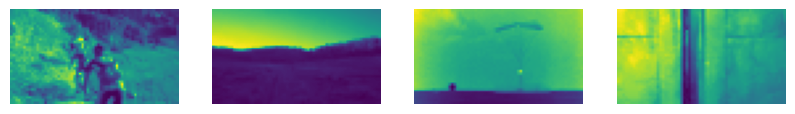

In [6]:
fig, axs = plt.subplots(1,4, figsize=(10,2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(batch["screen"][i, 0, 0]) # video frames that the mouse sees
    ax.axis("off");

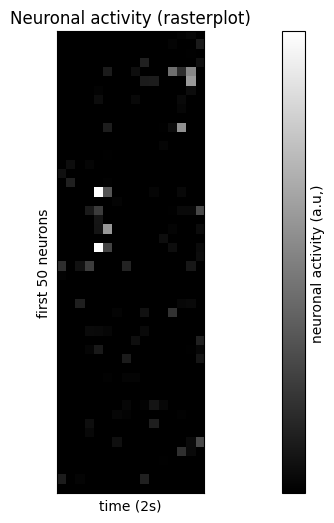

In [7]:
n_neurons = 50

fig, axs = plt.subplots(1,1, figsize=(20,6))
c = axs.imshow(batch["responses"][0,:, :n_neurons].T, vmin=0, cmap="gray")
axs.set(ylabel=f"first {n_neurons} neurons", 
        xlabel="time (2s)", 
        xticks=[],
        yticks=[],
        title="Neuronal activity (rasterplot)")
ax = plt.colorbar(c)
ax.ax.set(yticks=[], ylabel="neuronal activity (a.u,)");